# Introduction

## Summary

Here genes are correlated with bidirectional transcripts from other chromosomes to asses the false positive rate. The hypothesis is that we would find more pairs from within chromosome comparison compared to outside chromosome comparison. The main caveat being we also expect a small fraction of true pairs from outside chromosome comparisons. In other words, we can not distinguish indirect interactions due to TF binding across chromosomes.

The significant pairs for all genes was collected for pairs with FDR < 0.01 across all tissues.


## Results

In summary, we found over 80% of the genes to have more bidirectional transcripts asssigned to them in DBNascent pairs compared to the shuffled chromosome pairs. Suggesting that we capture true signal, regardless of the noise.


# Libraries

In [1]:
library(data.table) ## load files into R faster
library(ggplot2) ## plotting package
library(cowplot) ## plots + arrange plots etc
library(dplyr) ## data wrangling


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

## Assess false positive rate

In [2]:
count_num_genes <- function(chr_sig_original, chr_sig_swapped){
    
    #' get number of bidirectionals assigned to a genes
    
    #1. Get unique pairs across tissues
    chr_sig_uniq_original <- unique(chr_sig_original[, c('transcript1_chrom',
                                                         'transcript_1',
                                                         'transcript_2')])
    
    
    chr_sig_uniq_swapped <- unique(chr_sig_swapped[, c('transcript1_chrom',
                                                       'transcript_1',
                                                       'transcript_2')])
    
    #2. Count the number of bidirectionals assigned to a gene
    num_bidirs_per_gene_original <- as.data.frame(table(as.character(chr_sig_uniq_original$transcript_1)))
    num_bidirs_per_gene_swapped <- as.data.frame(table(as.character(chr_sig_uniq_swapped$transcript_1)))
    print(paste0("Number of genes (Original) = ", nrow(num_bidirs_per_gene_original)))
    print(paste0("Number of genes (Swapped) = ", nrow(num_bidirs_per_gene_swapped)))
    
    #3. Merge the bidirectional assigned tables
    num_bidirs_per_gene_merged <-merge(num_bidirs_per_gene_original, 
                                       num_bidirs_per_gene_swapped, 
                                       by='Var1')
    colnames(num_bidirs_per_gene_merged) <- c('gene',
                                              'og_bidirs',
                                              'swapped_bidirs')
    print(paste0("Shared genes = ", nrow(num_bidirs_per_gene_merged)))    
    return(num_bidirs_per_gene_merged)
}

# Load data

## Bidirectional and gene summaries

In [3]:
gene_bidir_tpm_summary_allBidirs_filteredSamples <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/gene_bidir_tpm_summary_allBidirs_filteredSamples.tsv.gz')
head(gene_bidir_tpm_summary_allBidirs_filteredSamples, 3)

chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.07209929,0.005198307,6.760542,0.009002053,0.0000000,8.0092052,1.252323,0,29,3.861518,genes
chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.19045740,0.036274023,163.616971,0.217865474,0.1674576,0.8741973,1.587046,0,749,99.733688,genes
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.00000000,0.000000000,0.000000,0.000000000,0.0000000,NA,0.000000,0,0,0.000000,genes


## DBNascent significant pairs

In [4]:
sig_pairs_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant"

##get paths for the tables
corr_sig_files <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
corr_sig_DT_list <- lapply(corr_sig_files,
                       data.table::fread,
                       nThread = 10) 

#merge the pairs lists
corr_sig_DT <- do.call(rbind, corr_sig_DT_list)
nrow(corr_sig_DT)
head(corr_sig_DT, 3)

[1] 12697055

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,749695,750013,chr10:749695-750013,⋯,2.806579e-05,0.0003002834,4,188.756638,-701308,-702967,upstream,blood,1.801802,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,969848,970172,chr10:969848-970172,⋯,3.415461e-04,0.0026924465,40,3.935736,-921464,-923123,upstream,blood,18.018018,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,972700,973240,chr10:972700-973240,⋯,2.162608e-04,0.0018123629,47,4.024305,-924424,-926083,upstream,blood,21.171171,intergenic


## Shuffled significant pairs

In [5]:
sig_pairs_sampled_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_shuffled_significant"

##get paths for the tables
corr_sig_sampled_files <- list.files(path=sig_pairs_sampled_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
corr_sig_sampled_DT_list <- lapply(corr_sig_sampled_files,
                       data.table::fread,
                       nThread = 10) 

#merge the pairs lists
corr_sig_sampled_DT <- do.call(rbind, corr_sig_sampled_DT_list)
nrow(corr_sig_sampled_DT)
head(corr_sig_sampled_DT, 3)

[1] 7280226

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,787365,787695,chr10:787365-787695,⋯,2.294186e-05,4.178794e-04,5,45.782436,-738984,-740643,upstream,blood,2.252252,intergenic
chr10,180743,249790,ZMYND11:NM_001202467.1,.,+,chr10,79981,81765,chr10:79981-81765,⋯,2.361846e-05,4.284305e-04,170,4.349340,-99870,-168917,upstream,blood,76.576577,intergenic
chr10,180743,249790,ZMYND11:NM_001202467.1,.,+,chr10,86080,86290,chr10:86080-86290,⋯,4.305133e-12,4.102824e-10,99,7.903269,-94558,-163605,upstream,blood,44.594595,intergenic


# Compare number of bidirectionals assigned to gene

## Count number of bidirectionals

In [6]:
num_bidirs_per_gene <- count_num_genes(corr_sig_DT, 
                                       corr_sig_sampled_DT) 

[1] "Number of genes (Original) = 27822"
[1] "Number of genes (Swapped) = 27780"
[1] "Shared genes = 27719"


In [7]:
##get difference
num_bidirs_per_gene$difference <- num_bidirs_per_gene$og_bidirs - num_bidirs_per_gene$swapped_bidirs
    
##merge gene summaries with metadata
num_bidirs_per_gene_meta <- merge(num_bidirs_per_gene, 
                                       gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                           by.x='gene',
                                           by.y='gene_transcript')

dim(num_bidirs_per_gene_meta)
head(num_bidirs_per_gene_meta, 3)

[1] 27719    21

,gene,og_bidirs,swapped_bidirs,difference,chrom,start,stop,score,strand,length,⋯,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type
,<fct>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
1,A1BG-AS1:NR_015380.2,393,176,217,chr19,58352719,58355183,.,+,2465,⋯,20.0041173,3281.04567,4.36890235,3.273834687,1.0237345,39.844387,0,730,97.20373,genes
2,A1BG:NM_130786.4,325,148,177,chr19,58345182,58352742,.,-,7561,⋯,0.8792051,777.31837,1.03504444,0.827704724,0.9059122,10.714507,0,749,99.73369,genes
3,A1CF:NM_014576.4,103,108,-5,chr10,50799408,50884877,.,-,85470,⋯,0.3549849,57.06898,0.07599065,0.001479047,7.8405178,8.448126,0,529,70.43941,genes


In [8]:
max(num_bidirs_per_gene_meta$og_bidirs)
max(num_bidirs_per_gene_meta$swapped_bidirs)

[1] 914

[1] 441

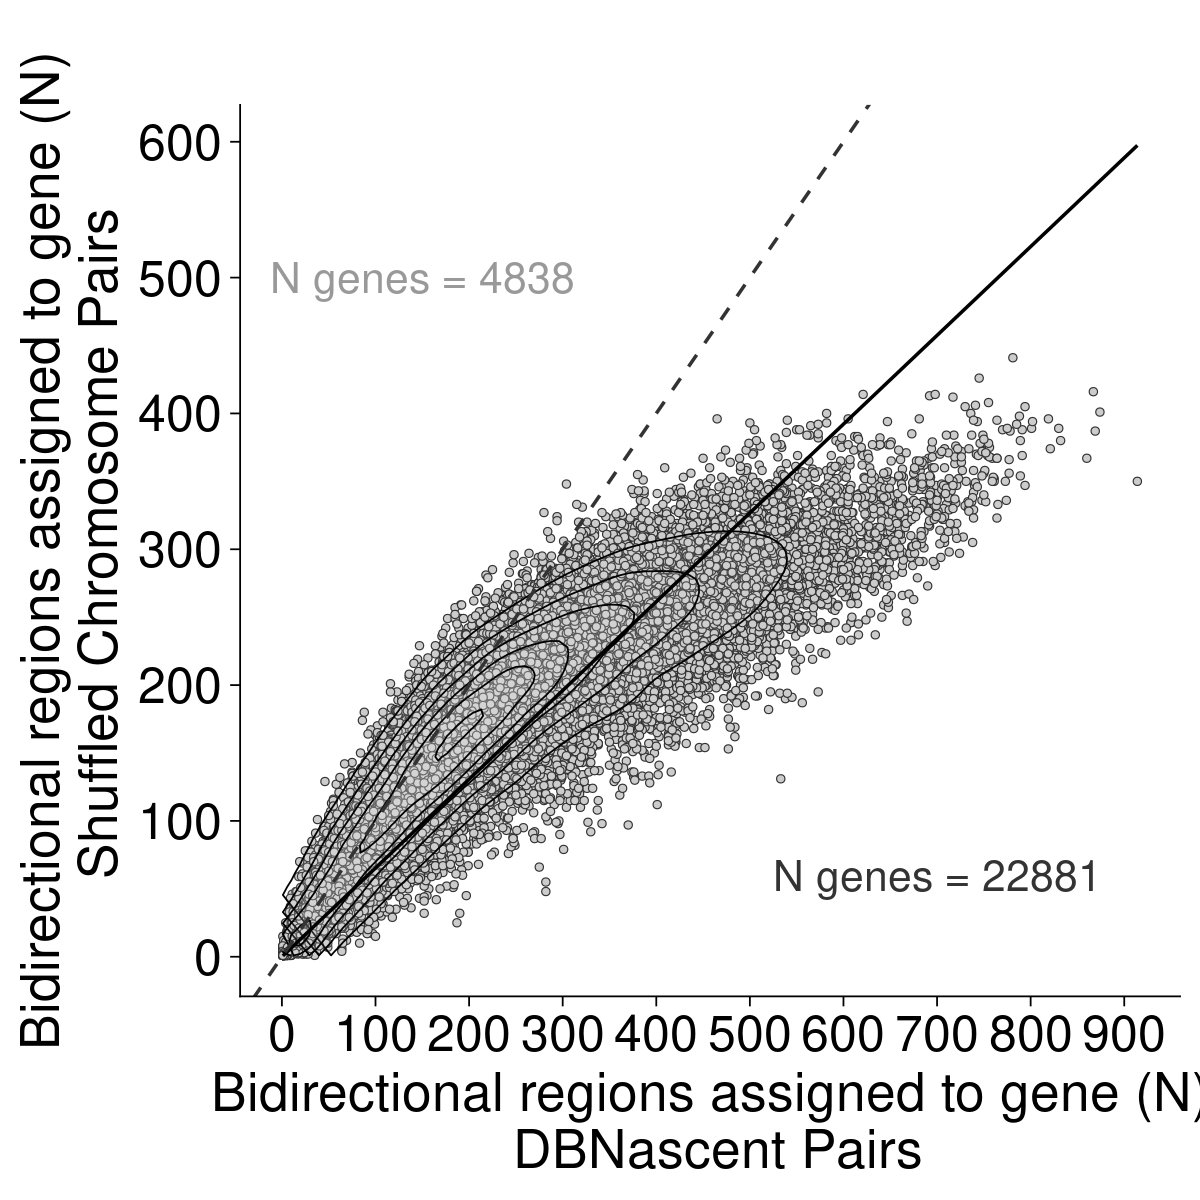

In [9]:
options(repr.plot.width=10, repr.plot.height=10)

num_bidirs_all_genes <- ggplot(num_bidirs_per_gene_meta,
                          aes(x=og_bidirs, y=swapped_bidirs)) +
geom_point(shape = 21, size=2, color='gray20', fill='gray80', alpha=1) + 
stat_density_2d(aes(fill = after_stat(level)), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_smooth(method = "lm", se = FALSE, color = 'black', formula=y~x+0) +
geom_abline(intercept = 0, slope=1, linetype='dashed', color = 'gray20', linewidth=1) +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Bidirectional regions assigned to gene (N)\n DBNascent Pairs") +
ylab("Bidirectional regions assigned to gene (N)\n Shuffled Chromosome Pairs") +
annotate("text", x = 700,
         y = 60, size=9, 
         label = paste0("N genes = ",nrow(subset(num_bidirs_per_gene, difference >= 0))),
         color='gray20') +
annotate("text", x = 150,
         y = 500, size=9,
         label = paste0("N genes = ",nrow(subset(num_bidirs_per_gene, difference < 0))),
         color='gray60') +
labs(fill=" ") +
scale_x_continuous(#expand = c(0, 0), 
                   #limits = c(0,270),
                  breaks=seq(0,920,100)) +
scale_y_continuous(#expand = c(0, 0), 
                   #limits = c(0,270),
                  breaks=seq(0,920,100)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 32), 
      axis.text = element_text(size = 30)) 

num_bidirs_all_genes

In [10]:
ggsave(num_bidirs_all_genes, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_bidirs_per_gene_original_vs_sampled.pdf',
      bg = "transparent")

ggsave(num_bidirs_all_genes, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_bidirs_per_gene_original_vs_sampled.png',
      bg = "transparent")

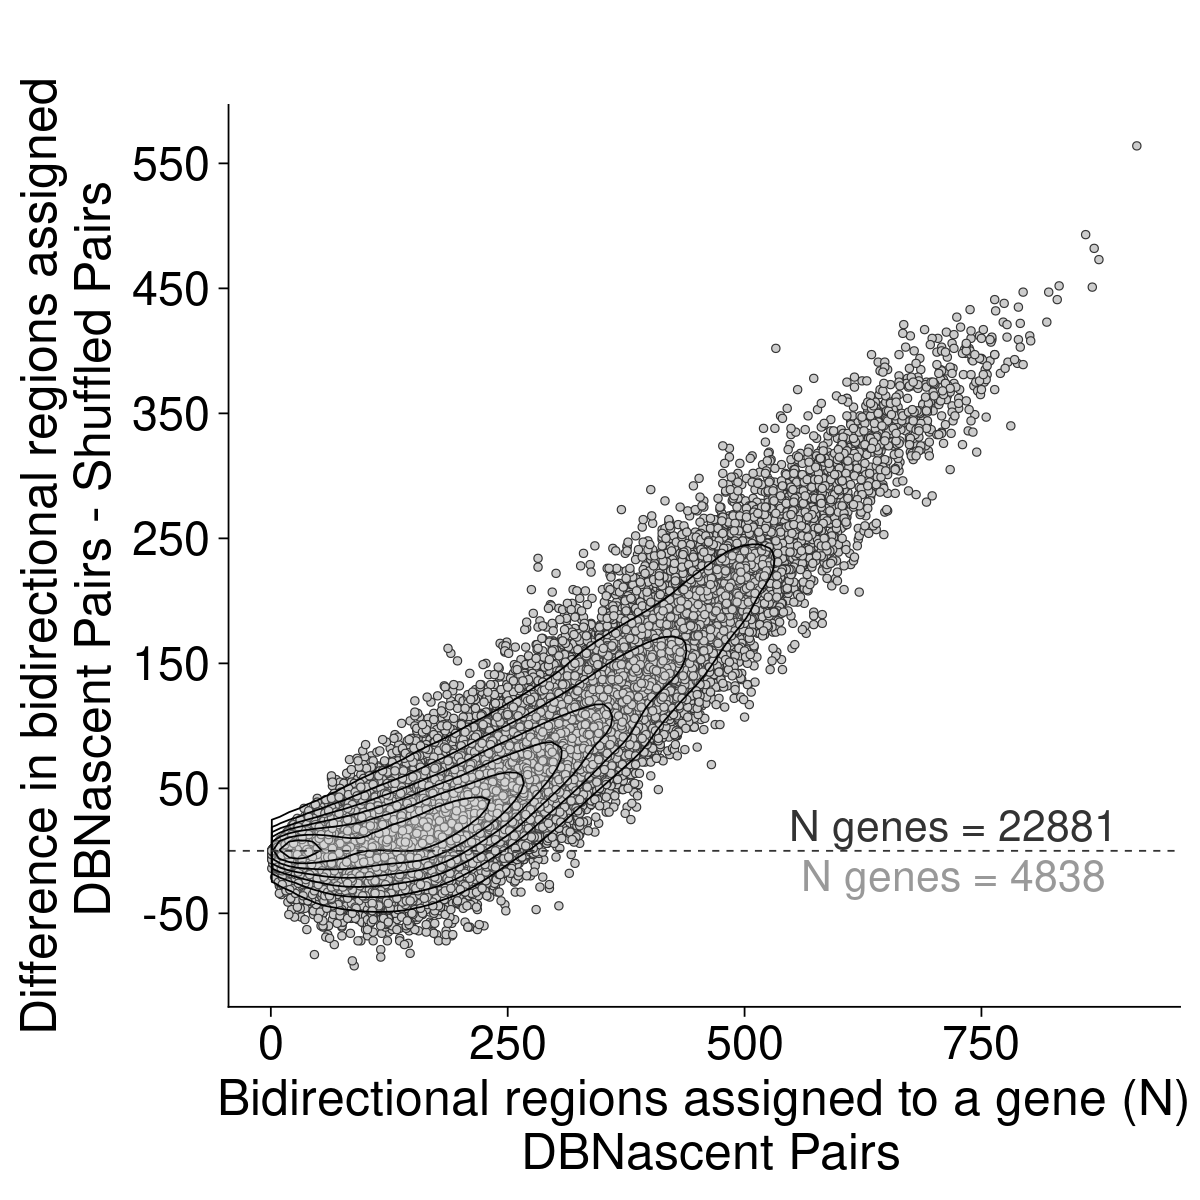

In [11]:
options(repr.plot.width=10, repr.plot.height=10)

num_bidirs_all_genes_diff2 <- ggplot(num_bidirs_per_gene_meta,
                               aes(x=og_bidirs,#log(mean, 2),
                         y=difference)
                          ) +
geom_point(shape = 21, size=2, color='gray20', fill='gray80', alpha=1) + 
stat_density_2d(aes(fill = after_stat(level)), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_hline(yintercept=0, linetype="dashed", color = "gray20") +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Bidirectional regions assigned to a gene (N)\n DBNascent Pairs") +
ylab("Difference in bidirectional regions assigned\n DBNascent Pairs - Shuffled Pairs") +
scale_y_continuous(breaks=seq(-950,950,100)) +
annotate("text", x = 720,
         y = 20, size=9, 
         label = paste0("N genes = ",nrow(subset(num_bidirs_per_gene, difference >= 0))),
         color='gray20') +
annotate("text", x = 720,
         y = -20, size=9,
         label = paste0("N genes = ",nrow(subset(num_bidirs_per_gene, difference < 0))),
         color='gray60') +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

num_bidirs_all_genes_diff2

In [12]:
ggsave(num_bidirs_all_genes_diff2, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_bidirs_per_gene_original_vs_sampled_difference.pdf',
      bg = "transparent")

ggsave(num_bidirs_all_genes_diff2, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_bidirs_per_gene_original_vs_sampled_difference.png',
      bg = "transparent")

In [13]:
100*(nrow(subset(num_bidirs_per_gene, difference >= 0))/(nrow(subset(num_bidirs_per_gene, difference < 0)) + nrow(subset(num_bidirs_per_gene, difference >= 0))))

[1] 82.54627

# Session information

In [14]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_1.1.4       cowplot_1.1.3     ggplot2_3.5.1     data.table_1.16.2

loaded via a namespace (and not attached):
 [1] Matrix_1.7-1      gtable_0.3.6      jsonlite_1.8.9    compiler_4.4.0   
 [5] crayon_1.5.3      tidyselect_1.2.1  IRdisplay_1.1     textsha